In [1]:
%load_ext autoreload
%autoreload 2    

In [2]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time
import pandas as pd 
import matplotlib.pyplot as plt
from IPython.display import clear_output
import cv2
import torchmetrics

import albumentations as A
from albumentations.pytorch import ToTensorV2

# own modules
from models import * 
from utils import * 
from data_loader import PH2, DRIVE

In [3]:
import numpy as np

# ! pip install opencv-python==4.5.5.64
import cv2 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Training Parameters 

In [5]:
size = 256
batch_size = 16
num_epochs = 200

In [6]:
train_transform = A.Compose(
    [
        A.Resize(size, size),
        A.Rotate(limit=90, p=1, border_mode=cv2.BORDER_CONSTANT),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.GaussNoise(p=0.5),
        A.Flip(p=0.5),
        A.Normalize(),
        ToTensorV2(),
        
    ]
)

test_transform = A.Compose([A.Resize(size, size), 
                            A.Normalize(),
                            ToTensorV2()])

In [7]:
trainset = PH2('train', transform=train_transform) # test_transform for no augment
valset = PH2('val', transform=test_transform)
testset = PH2('test', transform=test_transform)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8,)# persistent_workers=True, pin_memory=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=8,)# persistent_workers=True, pin_memory=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8,)# persistent_workers=True, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


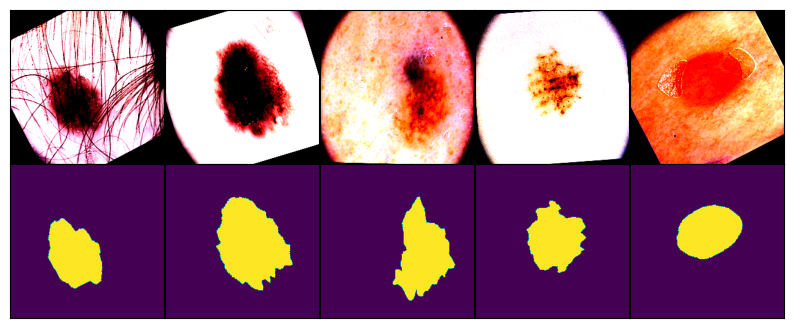

In [8]:
visualize_img_and_label(trainset)

# Model

# Train

In [9]:
def train(model, opt, loss_fn, epochs, train_loader, val_loader, test_loader):

    train_loss = []
    val_loss = []


    metric_dict = {
                'train_dice': torchmetrics.Dice().to(device),
                'train_iou': torchmetrics.JaccardIndex('binary').to(device),
                'train_acc': torchmetrics.Accuracy('binary').to(device),
                'train_sens': Sensitivity().to(device),
                'train_spec': torchmetrics.Specificity('binary').to(device),
                
                'val_dice': torchmetrics.Dice().to(device),
                'val_iou': torchmetrics.JaccardIndex('binary').to(device),
                'val_acc': torchmetrics.Accuracy('binary').to(device),
                'val_sens': Sensitivity().to(device),
                'val_spec': torchmetrics.Specificity('binary').to(device),

                                
                'test_dice': torchmetrics.Dice().to(device),
                'test_iou': torchmetrics.JaccardIndex('binary').to(device),
                'test_acc': torchmetrics.Accuracy('binary').to(device),
                'test_sens': Sensitivity().to(device),
                'test_spec': torchmetrics.Specificity('binary').to(device),
               }

    out_dict = {
                
                'train_loss':[],
                'train_dice': [],
                'train_iou': [],
                'train_acc': [],
                'train_sens': [],
                'train_spec': [],

                'val_loss':[],
                'val_dice': [],
                'val_iou':[],
                'val_acc': [],
                'val_sens': [],
                'val_spec': [],

                                
                'test_dice': [],
                'test_iou': [],
                'test_acc': [],
                'test_sens': [],
                'test_spec': [],
    }

    
    for epoch in range(epochs):
        tic = time()
        
        avg_loss = 0
        avg_loss_val = 0
        
        model.train()  # train mode
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            Y_batch = Y_batch.unsqueeze(1)
            loss = loss_fn(F.sigmoid(Y_pred), Y_batch)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(train_loader)

            metric_dict['train_dice'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_acc'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_iou'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_sens'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_spec'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))

            
        toc = time()

        model.eval()  # testing mode
        for X_batch, Y_batch in val_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            
            Y_pred = model(X_batch)
            Y_batch = Y_batch.unsqueeze(1)
            loss_test = loss_fn(Y_pred, Y_batch)  # forward-pass
            avg_loss_val += loss / len(val_loader)

            metric_dict['val_dice'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_acc'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_iou'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_sens'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_spec'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            
        
        train_loss.append(avg_loss.detach().cpu())
        val_loss.append(avg_loss_val.detach().cpu())

        #plt.plot(train_loss, np.arange(len(train_loss)))
        #plt.plot(test_loss, np.arange(len(test_loss)))
                 
        for metric in ['dice', 'acc', 'iou', 'sens', 'spec']:
            out_dict['train_' + metric].append(metric_dict['train_' + metric].compute().detach().cpu())
            out_dict['val_' + metric].append(metric_dict['val_' + metric].compute().detach().cpu())

        
        print(f"Loss train: {avg_loss:.3f}\t Val Acc: {metric_dict['val_acc'].compute():.3f}\t, Val Dice: {metric_dict['val_dice'].compute()}")

    model.eval()  # testing mode
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        
        Y_pred = model(X_batch)
        Y_batch = Y_batch.unsqueeze(1)

        metric_dict['test_dice'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_acc'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_iou'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_sens'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_spec'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))

    for metric in ['dice', 'acc', 'iou', 'sens', 'spec']:
        out_dict['test_' + metric].append(metric_dict['test_' + metric].compute().detach().cpu())

    out_dict['train_loss'] = train_loss
    out_dict['val_loss'] = val_loss
    
    
    return out_dict, metric_dict


    
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [F.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)

In [10]:
a = 0
for i in range(160):
    l, m = trainset.__getitem__(1)
    a += m.sum() 

# good weight is 11 
(256*256) /( a /160) 

tensor(5.1469, dtype=torch.float64)

Loss train: 0.731	 Val Acc: 0.611	, Val Dice: 0.0
Loss train: 0.671	 Val Acc: 0.686	, Val Dice: 0.34924349188804626
Loss train: 0.657	 Val Acc: 0.724	, Val Dice: 0.498797744512558
Loss train: 0.646	 Val Acc: 0.746	, Val Dice: 0.5732786059379578
Loss train: 0.636	 Val Acc: 0.758	, Val Dice: 0.6116738319396973
Loss train: 0.631	 Val Acc: 0.767	, Val Dice: 0.6374577879905701
Loss train: 0.632	 Val Acc: 0.773	, Val Dice: 0.6559085249900818
Loss train: 0.630	 Val Acc: 0.778	, Val Dice: 0.6656932830810547
Loss train: 0.633	 Val Acc: 0.781	, Val Dice: 0.6759483218193054
Loss train: 0.630	 Val Acc: 0.784	, Val Dice: 0.6817269921302795
Loss train: 0.628	 Val Acc: 0.787	, Val Dice: 0.6881095170974731
Loss train: 0.626	 Val Acc: 0.788	, Val Dice: 0.6941262483596802
Loss train: 0.628	 Val Acc: 0.790	, Val Dice: 0.698519766330719
Loss train: 0.625	 Val Acc: 0.792	, Val Dice: 0.7022848129272461
Loss train: 0.626	 Val Acc: 0.793	, Val Dice: 0.7061155438423157
Loss train: 0.626	 Val Acc: 0.794	, Val D

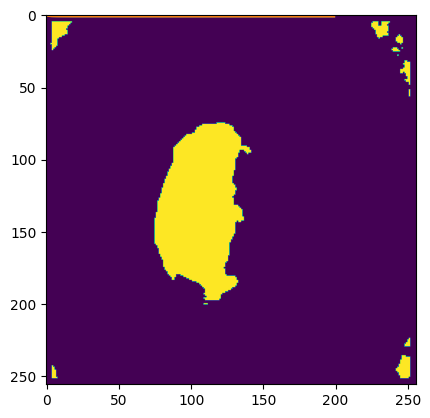

Loss train: 0.737	 Val Acc: 0.611	, Val Dice: 0.0
Loss train: 0.673	 Val Acc: 0.691	, Val Dice: 0.36715757846832275
Loss train: 0.647	 Val Acc: 0.729	, Val Dice: 0.5273473858833313
Loss train: 0.649	 Val Acc: 0.743	, Val Dice: 0.5596424341201782
Loss train: 0.648	 Val Acc: 0.753	, Val Dice: 0.5819950103759766
Loss train: 0.640	 Val Acc: 0.762	, Val Dice: 0.604690670967102
Loss train: 0.641	 Val Acc: 0.768	, Val Dice: 0.6221116781234741
Loss train: 0.640	 Val Acc: 0.774	, Val Dice: 0.6356030702590942
Loss train: 0.637	 Val Acc: 0.778	, Val Dice: 0.6453453302383423
Loss train: 0.637	 Val Acc: 0.782	, Val Dice: 0.6541052460670471
Loss train: 0.635	 Val Acc: 0.786	, Val Dice: 0.6629239320755005
Loss train: 0.631	 Val Acc: 0.789	, Val Dice: 0.6700541377067566
Loss train: 0.631	 Val Acc: 0.793	, Val Dice: 0.6770687103271484
Loss train: 0.632	 Val Acc: 0.794	, Val Dice: 0.6807295083999634
Loss train: 0.635	 Val Acc: 0.796	, Val Dice: 0.6854300498962402
Loss train: 0.634	 Val Acc: 0.799	, Val 

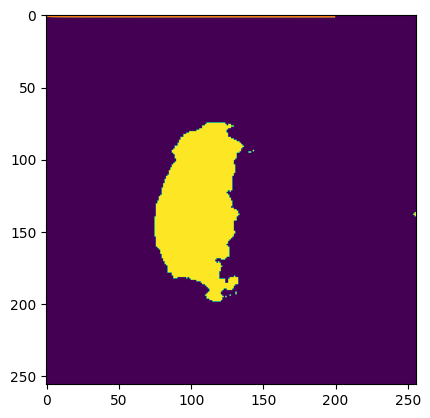

Loss train: 1.324	 Val Acc: 0.801	, Val Dice: 0.7532622218132019
Loss train: 1.171	 Val Acc: 0.780	, Val Dice: 0.7364822626113892
Loss train: 1.138	 Val Acc: 0.771	, Val Dice: 0.7363032102584839
Loss train: 1.146	 Val Acc: 0.768	, Val Dice: 0.7364026308059692
Loss train: 1.130	 Val Acc: 0.765	, Val Dice: 0.7364473342895508
Loss train: 1.120	 Val Acc: 0.765	, Val Dice: 0.7370041608810425
Loss train: 1.115	 Val Acc: 0.766	, Val Dice: 0.7381938099861145
Loss train: 1.116	 Val Acc: 0.767	, Val Dice: 0.739383339881897
Loss train: 1.116	 Val Acc: 0.767	, Val Dice: 0.7395579218864441
Loss train: 1.101	 Val Acc: 0.766	, Val Dice: 0.739434003829956
Loss train: 1.130	 Val Acc: 0.768	, Val Dice: 0.7404202818870544
Loss train: 1.103	 Val Acc: 0.766	, Val Dice: 0.7398040294647217
Loss train: 1.104	 Val Acc: 0.767	, Val Dice: 0.740254282951355
Loss train: 1.137	 Val Acc: 0.768	, Val Dice: 0.7411645650863647
Loss train: 1.100	 Val Acc: 0.766	, Val Dice: 0.7399726510047913
Loss train: 1.106	 Val Acc: 

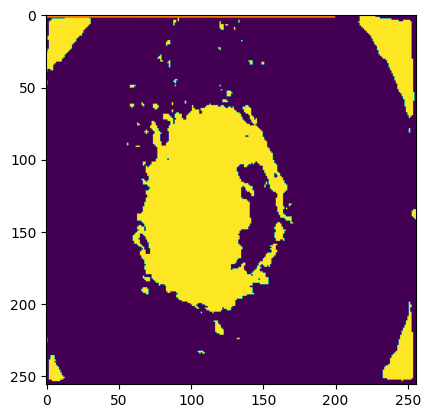

Loss train: 1.320	 Val Acc: 0.797	, Val Dice: 0.7587644457817078
Loss train: 1.179	 Val Acc: 0.781	, Val Dice: 0.7524860501289368
Loss train: 1.174	 Val Acc: 0.776	, Val Dice: 0.7505620121955872
Loss train: 1.192	 Val Acc: 0.779	, Val Dice: 0.7521783113479614
Loss train: 1.167	 Val Acc: 0.776	, Val Dice: 0.751075267791748
Loss train: 1.160	 Val Acc: 0.772	, Val Dice: 0.7488168478012085
Loss train: 1.162	 Val Acc: 0.772	, Val Dice: 0.7485553026199341
Loss train: 1.159	 Val Acc: 0.773	, Val Dice: 0.7490770816802979
Loss train: 1.166	 Val Acc: 0.772	, Val Dice: 0.748473584651947
Loss train: 1.142	 Val Acc: 0.771	, Val Dice: 0.7481759190559387
Loss train: 1.135	 Val Acc: 0.771	, Val Dice: 0.7479827404022217
Loss train: 1.144	 Val Acc: 0.771	, Val Dice: 0.7485764026641846
Loss train: 1.144	 Val Acc: 0.772	, Val Dice: 0.7493480443954468
Loss train: 1.134	 Val Acc: 0.772	, Val Dice: 0.7495271563529968
Loss train: 1.152	 Val Acc: 0.773	, Val Dice: 0.7508213520050049
Loss train: 1.133	 Val Acc:

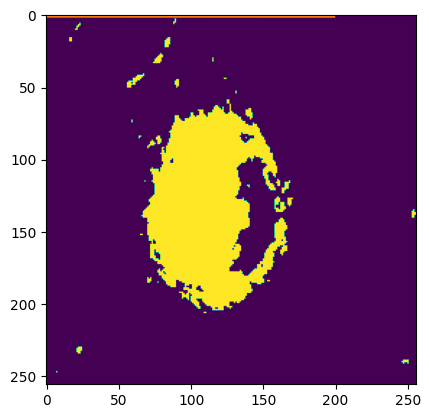

Loss train: 0.157	 Val Acc: 0.611	, Val Dice: 0.0
Loss train: 0.131	 Val Acc: 0.691	, Val Dice: 0.3709121644496918
Loss train: 0.118	 Val Acc: 0.728	, Val Dice: 0.5143980979919434
Loss train: 0.116	 Val Acc: 0.749	, Val Dice: 0.5825743675231934
Loss train: 0.112	 Val Acc: 0.761	, Val Dice: 0.6132966876029968
Loss train: 0.111	 Val Acc: 0.770	, Val Dice: 0.638210117816925
Loss train: 0.109	 Val Acc: 0.776	, Val Dice: 0.6563281416893005
Loss train: 0.110	 Val Acc: 0.781	, Val Dice: 0.669135332107544
Loss train: 0.109	 Val Acc: 0.784	, Val Dice: 0.6786590814590454
Loss train: 0.108	 Val Acc: 0.787	, Val Dice: 0.686761200428009
Loss train: 0.109	 Val Acc: 0.790	, Val Dice: 0.6929810643196106
Loss train: 0.108	 Val Acc: 0.792	, Val Dice: 0.6985321640968323
Loss train: 0.108	 Val Acc: 0.793	, Val Dice: 0.7029315829277039
Loss train: 0.108	 Val Acc: 0.794	, Val Dice: 0.7063326239585876
Loss train: 0.107	 Val Acc: 0.796	, Val Dice: 0.7093281149864197
Loss train: 0.108	 Val Acc: 0.797	, Val Dic

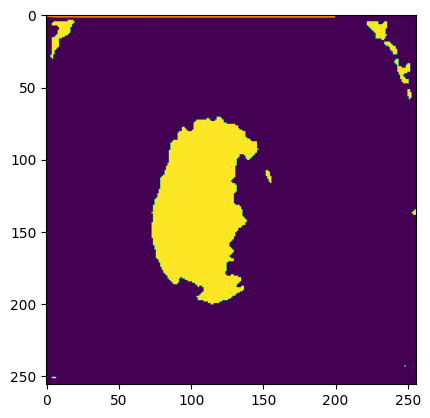

Loss train: 0.165	 Val Acc: 0.611	, Val Dice: 0.0
Loss train: 0.129	 Val Acc: 0.685	, Val Dice: 0.34912434220314026
Loss train: 0.122	 Val Acc: 0.723	, Val Dice: 0.5054018497467041
Loss train: 0.116	 Val Acc: 0.739	, Val Dice: 0.5504022240638733
Loss train: 0.117	 Val Acc: 0.752	, Val Dice: 0.5876072645187378
Loss train: 0.115	 Val Acc: 0.760	, Val Dice: 0.6084004640579224
Loss train: 0.116	 Val Acc: 0.766	, Val Dice: 0.6227520108222961
Loss train: 0.115	 Val Acc: 0.770	, Val Dice: 0.6339256763458252
Loss train: 0.114	 Val Acc: 0.775	, Val Dice: 0.6439881324768066
Loss train: 0.114	 Val Acc: 0.778	, Val Dice: 0.6511580944061279
Loss train: 0.114	 Val Acc: 0.781	, Val Dice: 0.6578423976898193
Loss train: 0.114	 Val Acc: 0.785	, Val Dice: 0.66548752784729
Loss train: 0.113	 Val Acc: 0.787	, Val Dice: 0.6701816916465759
Loss train: 0.112	 Val Acc: 0.790	, Val Dice: 0.6757639646530151
Loss train: 0.111	 Val Acc: 0.790	, Val Dice: 0.6757051348686218
Loss train: 0.112	 Val Acc: 0.792	, Val D

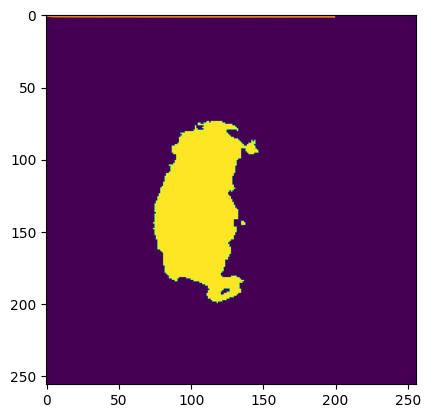

Loss train: 0.579	 Val Acc: 0.798	, Val Dice: 0.7534720301628113
Loss train: 0.538	 Val Acc: 0.770	, Val Dice: 0.740144670009613
Loss train: 0.530	 Val Acc: 0.775	, Val Dice: 0.7441185116767883
Loss train: 0.523	 Val Acc: 0.774	, Val Dice: 0.7446200847625732
Loss train: 0.524	 Val Acc: 0.769	, Val Dice: 0.7418064475059509
Loss train: 0.526	 Val Acc: 0.767	, Val Dice: 0.7417593002319336
Loss train: 0.526	 Val Acc: 0.766	, Val Dice: 0.7407826781272888
Loss train: 0.517	 Val Acc: 0.764	, Val Dice: 0.7399000525474548
Loss train: 0.526	 Val Acc: 0.767	, Val Dice: 0.741287887096405
Loss train: 0.532	 Val Acc: 0.767	, Val Dice: 0.7413157820701599
Loss train: 0.522	 Val Acc: 0.767	, Val Dice: 0.741880476474762
Loss train: 0.527	 Val Acc: 0.769	, Val Dice: 0.7430638074874878
Loss train: 0.529	 Val Acc: 0.767	, Val Dice: 0.742333173751831
Loss train: 0.516	 Val Acc: 0.769	, Val Dice: 0.743334174156189
Loss train: 0.530	 Val Acc: 0.771	, Val Dice: 0.744374692440033
Loss train: 0.533	 Val Acc: 0.7

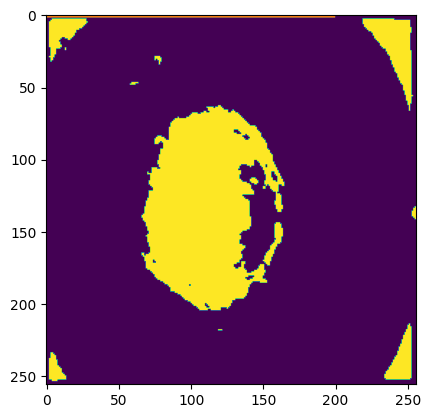

Loss train: 0.573	 Val Acc: 0.778	, Val Dice: 0.752846360206604
Loss train: 0.531	 Val Acc: 0.782	, Val Dice: 0.7547323107719421
Loss train: 0.526	 Val Acc: 0.778	, Val Dice: 0.7528505921363831
Loss train: 0.522	 Val Acc: 0.771	, Val Dice: 0.749601423740387
Loss train: 0.535	 Val Acc: 0.771	, Val Dice: 0.7498729228973389
Loss train: 0.525	 Val Acc: 0.767	, Val Dice: 0.7477688193321228
Loss train: 0.535	 Val Acc: 0.769	, Val Dice: 0.7494340538978577
Loss train: 0.522	 Val Acc: 0.768	, Val Dice: 0.7489442825317383
Loss train: 0.533	 Val Acc: 0.768	, Val Dice: 0.7479084730148315
Loss train: 0.517	 Val Acc: 0.770	, Val Dice: 0.7489742040634155
Loss train: 0.524	 Val Acc: 0.772	, Val Dice: 0.7503344416618347
Loss train: 0.520	 Val Acc: 0.774	, Val Dice: 0.7518143653869629
Loss train: 0.522	 Val Acc: 0.772	, Val Dice: 0.7512034177780151
Loss train: 0.524	 Val Acc: 0.774	, Val Dice: 0.752562403678894
Loss train: 0.526	 Val Acc: 0.777	, Val Dice: 0.753970742225647
Loss train: 0.529	 Val Acc: 0

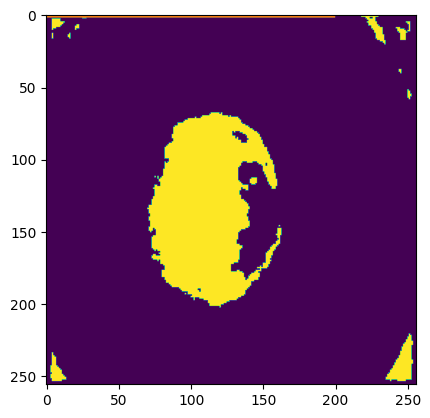

In [11]:
loss_function = {
'BCELoss':nn.BCEWithLogitsLoss(),
'BCELossWeighted':nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5.14]).cuda()),
'FocalLoss':FocalLoss(),
'DiceLoss':DiceLoss(),
}

for loss_name, loss_fn in loss_function.items():
    for aug in ['Augmentation', 'NoAugmentation']:
        
        if aug == 'Augmentation':
            trainset = PH2('train', transform=train_transform) # train_transform for augment
        else:
            trainset = PH2('train', transform=test_transform) # test_transform for no augment
            
        valset = PH2('val', transform=test_transform)
        testset = PH2('test', transform=test_transform)
        
        train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True, pin_memory=True)
        val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers=True, pin_memory=True)
        test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers=True, pin_memory=True)


        model = SimpleCNN().to(device)
        out_dict, metric_dict = train(model, optim.Adam(model.parameters(), 0.001), loss_fn, num_epochs, train_loader, val_loader, test_loader)

        plt.plot(np.arange(len(out_dict['train_dice'])), np.array(out_dict['train_dice'])) 
        plt.plot(np.arange(len(out_dict['val_dice'])), np.array(out_dict['val_dice'])) 

        out_dict['test_dice'] = np.repeat(out_dict['test_dice'], len(out_dict['train_dice']))
        out_dict['test_iou'] = np.repeat(out_dict['test_iou'], len(out_dict['train_dice']))
        out_dict['test_acc'] = np.repeat(out_dict['test_acc'], len(out_dict['train_dice']))
        out_dict['test_sens'] = np.repeat(out_dict['test_sens'], len(out_dict['train_dice']))
        out_dict['test_spec'] = np.repeat(out_dict['test_spec'], len(out_dict['train_dice']))

        pd.DataFrame(out_dict).astype(float).to_csv(f"results/PH2/SimpleCNN_{aug}_{loss_name}")

        im, lab = next(iter(test_loader))
        out = model(im.cuda())
        plt.imshow(F.sigmoid(out)[0].squeeze().detach().cpu() > 0.5)
        plt.show()
        